In [67]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tensorflow_addons as tfa
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [68]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [69]:

def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [70]:
def get_uncompiled_model(model_name, model_params_dict):
    assert model_name in ['resnet', 'mscalev2', 'mscalev1', 'mscalev2_custom_scale']

    if model_name == 'resnet':
        model = wispy.resnet.ResNet(**model_params_dict)
    elif model_name == 'mscalev2':
        model = wispy.mscalev2.build_model(**model_params_dict)
    elif model_name == 'mscalev1':
        model = pugna.models.mscalednn.build_model_2(**model_params_dict)
    elif model_name == 'mscalev2_custom_scale':
        model = build_model_custom_scales(**model_params_dict)

    return model


def get_compiled_model(model_name, model_params_dict, extra_params_dict):
    model = get_uncompiled_model(
        model_name=model_name, model_params_dict=model_params_dict)

    optimizer = tf.keras.optimizers.Adam(
        extra_params_dict['lr'], amsgrad=extra_params_dict['amsgrad'])

    model.compile(loss=extra_params_dict['loss'],
                  optimizer=optimizer, metrics=extra_params_dict['metrics'])

    return model

# load data

In [71]:
X_train = np.load('processed_training_data/X_train.npy')
y_train = np.load('processed_training_data/y_train.npy')

X_val = np.load('processed_training_data/X_val.npy')
y_val = np.load('processed_training_data/y_val.npy')

In [72]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")

X_train.shape: (11190, 10)
y_train.shape: (11190, 1)
X_val.shape: (2238, 10)
y_val.shape: (2238, 1)


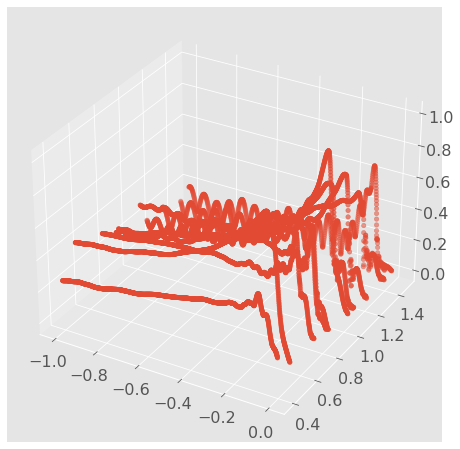

In [73]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,3], y_train[:,0])

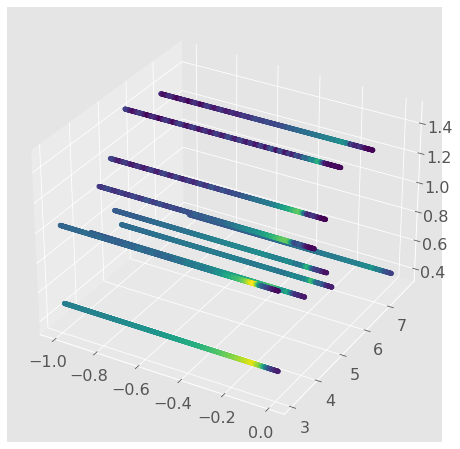

In [74]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], X_train[:,3], c=y_train[:,0])

# single waveform test - only time dimension

In [75]:
def extract_one_waveform(first_idx, X_train, y_train, X_val, y_val):
    return X_train.copy()[:first_idx,0].reshape(-1,1), y_train.copy()[:first_idx], X_val.copy()[:first_idx,0].reshape(-1,1), y_val.copy()[:first_idx]

In [76]:
data_one = {}
data_one['X_train'], data_one['y_train'], data_one['X_val'], data_one['y_val'] = extract_one_waveform(1119, X_train, y_train, X_val, y_val)

In [77]:
print(f"data_one['X_train'].shape: {data_one['X_train'].shape}")
print(f"data_one['y_train'].shape: {data_one['y_train'].shape}")
print(f"data_one['X_val'].shape: {data_one['X_val'].shape}")
print(f"data_one['y_val'].shape: {data_one['y_val'].shape}")

data_one['X_train'].shape: (1119, 1)
data_one['y_train'].shape: (1119, 1)
data_one['X_val'].shape: (1119, 1)
data_one['y_val'].shape: (1119, 1)


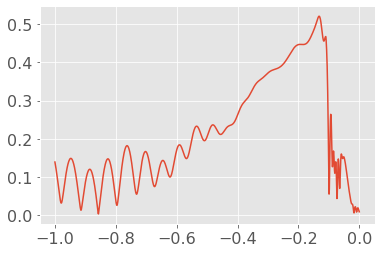

In [78]:
plt.figure()
plt.plot(data_one['X_train'][:,0], data_one['y_train'][:,0])

In [79]:
epochs = 1000
batch_size = data_one['X_train'].shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")


# model_name = "mscalev1"

# model_params_dict = dict(
#     input_shape=data_one['X_train'].shape[1],
#     output_shape=data_one['y_train'].shape[1],
#     mscale_units = 2048,
#     mscale_activation = 's2relu',
#     nscales = 2048,
#     scale_name = 'linear',
#     units = [256],
#     activation = 's2relu',
#     mscale_bias_initializer = [-0.05, 0.05]
# )


model_name = "mscalev2"

model_params_dict = dict(
    input_shape=data_one['X_train'].shape[1],
    output_shape=data_one['y_train'].shape[1],
    units = [128,128,128],
    activation = "s2relu",
    n_blocks = [2,2,2],
    scales = [1,10,100],
    layers_per_block = 3,
)

# model_name = "resnet"

# model_params_dict = dict(
#     input_shape=data_one['X_train'].shape[1],
#     output_shape=data_one['y_train'].shape[1],
#     width = 256,
#     num_blocks = 1,
#     group_norm = True,
#     groups = 1,
#     batch_norm = False,
#     momentum = 0.9
# )

extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]


sample_weight=None

# t_start = 0.7
# t_end = 1.
# sample_weight = np.ones(len(data_one['X_train']))
# mask = (data_one['X_train'][:, 0] > t_start) & (data_one['X_train'][:, 0] <= t_end)
# sample_weight[mask] = len(sample_weight) * 10000



batch_size: 1119


In [80]:
model = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

In [81]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer_7 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_8 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
__________________________________________________________________________________________________
scale_layer_9 (ScaleLayer)      (None, 1)            0           input_4[0][0]                    
____________________________________________________________________________________________

In [82]:
print("starting fit")
starttime = datetime.datetime.now()
history = model.fit(
    data_one['X_train'],
    data_one['y_train'],
    epochs=epochs,
    validation_data=(data_one['X_val'], data_one['y_val']),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

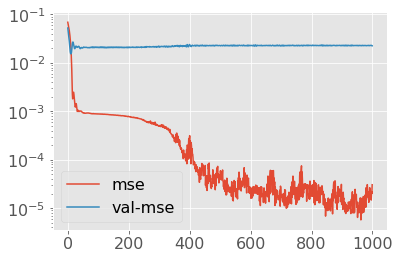

In [83]:
plt.figure()
plt.plot(history.history['mse'], label='mse')
plt.plot(history.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [84]:
yhat = model.predict(data_one['X_train'])

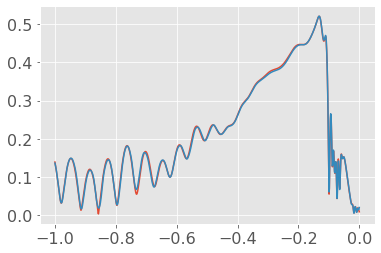

In [85]:
plt.figure()
plt.plot(data_one['X_train'][:,0], data_one['y_train'][:,0])
plt.plot(data_one['X_train'][:,0], yhat[:,0])
# plt.xlim(0.5, 1)

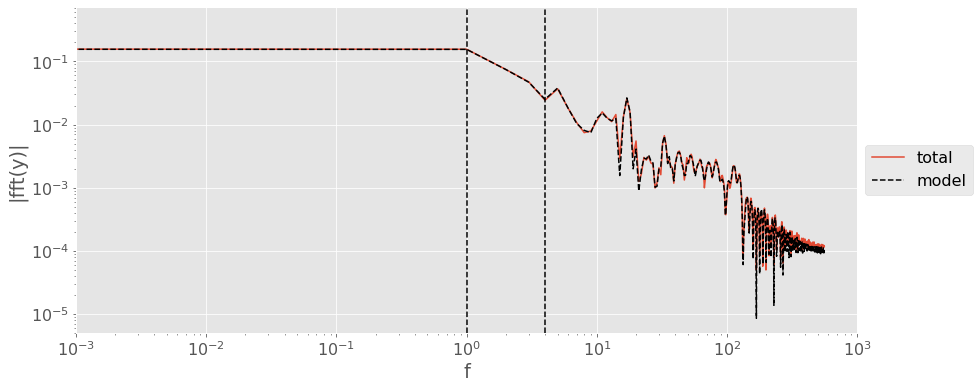

In [86]:
plot_fft(data_one['X_train'], data_one['y_train'], model=model, xlim=(1e-3, 1e3), logx=True, logy=True)

# single waveform test - time dimension and other dimesions

In [87]:
def extract_one_waveform_v2(first_idx, X_train, y_train, X_val, y_val, ncols=4):
    return X_train.copy()[:first_idx,:ncols], y_train.copy()[:first_idx], X_val.copy()[:first_idx,:ncols], y_val.copy()[:first_idx]

In [88]:
data_one_v2 = {}
data_one_v2['X_train'], data_one_v2['y_train'], data_one_v2['X_val'], data_one_v2['y_val'] = \
    extract_one_waveform_v2(1119, X_train, y_train, X_val, y_val, ncols=4)

In [89]:
print(f"data_one_v2['X_train'].shape: {data_one_v2['X_train'].shape}")
print(f"data_one_v2['y_train'].shape: {data_one_v2['y_train'].shape}")
print(f"data_one_v2['X_val'].shape: {data_one_v2['X_val'].shape}")
print(f"data_one_v2['y_val'].shape: {data_one_v2['y_val'].shape}")

data_one_v2['X_train'].shape: (1119, 4)
data_one_v2['y_train'].shape: (1119, 1)
data_one_v2['X_val'].shape: (1119, 4)
data_one_v2['y_val'].shape: (1119, 1)


In [125]:
data_one_v2["X_train"][:,0]

array([-1.00000000e+00, -9.99105546e-01, -9.98211091e-01, ...,
       -1.78890877e-03, -8.94454383e-04,  0.00000000e+00])

In [127]:
data_one_v2["X_train"]

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       ...,
       [-1.78890877e-03,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-8.94454383e-04,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [ 0.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00]])

In [91]:
# data_one_v2['X_train'][:,1] = data_one_v2['X_train'][:,1]/6
# data_one_v2['X_val'][:,1] = data_one_v2['X_val'][:,1]/6

In [92]:
data_one_v2['X_train']

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       ...,
       [-1.78890877e-03,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-8.94454383e-04,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [ 0.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00]])

In [93]:
# here I am seeing if having the other columns to be O(1) will help the fitting
def make_fake_scaled_data(X, factor):
    return np.column_stack((X[:,0].reshape(-1, 1), factor*np.ones(X[:,1:].shape)))

In [94]:
data_one_v2['X_train_FAKE'] = make_fake_scaled_data(data_one_v2['X_train'], factor=1)
data_one_v2['X_val_FAKE'] = make_fake_scaled_data(data_one_v2['X_val'], factor=2)

In [95]:
epochs = 1000
batch_size = data_one_v2['X_train'].shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")


# model_name = "mscalev1"

# model_params_dict = dict(
#     input_shape=data_one_v2['X_train'].shape[1],
#     output_shape=data_one_v2['y_train'].shape[1],
#     mscale_units = 2048,
#     mscale_activation = 's2relu',
#     nscales = 2048,
#     scale_name = 'linear',
#     units = [256],
#     activation = 's2relu',
#     mscale_bias_initializer = [-0.05, 0.05]
# )

model_name = "mscalev2"

model_params_dict = dict(
    input_shape=data_one_v2['X_train'].shape[1],
    output_shape=data_one_v2['y_train'].shape[1],
    units = [128,128,128],
    activation = "s2relu",
    n_blocks = [2,2,2],
    scales = [1,10,100],
    layers_per_block = 3,
)

# model_name = "resnet"

# model_params_dict = dict(
#     input_shape=data_one_v2['X_train'].shape[1],
#     output_shape=data_one_v2['y_train'].shape[1],
#     width = 256,
#     num_blocks = 1,
#     group_norm = True,
#     groups = 1,
#     batch_norm = False,
#     momentum = 0.9
# )


extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]
sample_weight=None

model_v2 = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

batch_size: 1119


In [96]:
model_v2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
scale_layer_10 (ScaleLayer)     (None, 4)            0           input_5[0][0]                    
__________________________________________________________________________________________________
scale_layer_11 (ScaleLayer)     (None, 4)            0           input_5[0][0]                    
__________________________________________________________________________________________________
scale_layer_12 (ScaleLayer)     (None, 4)            0           input_5[0][0]                    
____________________________________________________________________________________________

In [97]:
# data_one_v2['X_train'],
# data_one_v2['y_train'],
print("starting fit")
starttime = datetime.datetime.now()
history_v2 = model_v2.fit(
    data_one_v2['X_train'],
    data_one_v2['y_train'],
    epochs=epochs,
    validation_data=(data_one_v2['X_val'], data_one_v2['y_val']),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

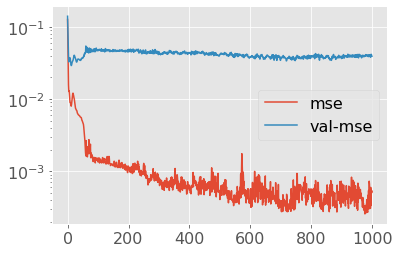

In [98]:
plt.figure()
plt.plot(history_v2.history['mse'], label='mse')
plt.plot(history_v2.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [99]:
yhat_v2 = model_v2.predict(data_one_v2['X_train'])
# yhat_v2 = model_v2.predict(data_one_v2['X_train_FAKE'])

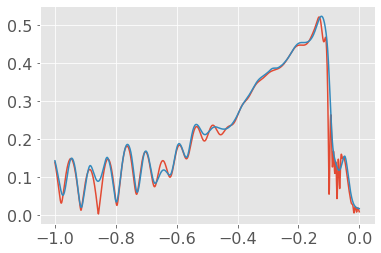

In [100]:
plt.figure()
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0])
plt.plot(data_one_v2['X_train'][:,0], yhat_v2[:,0])

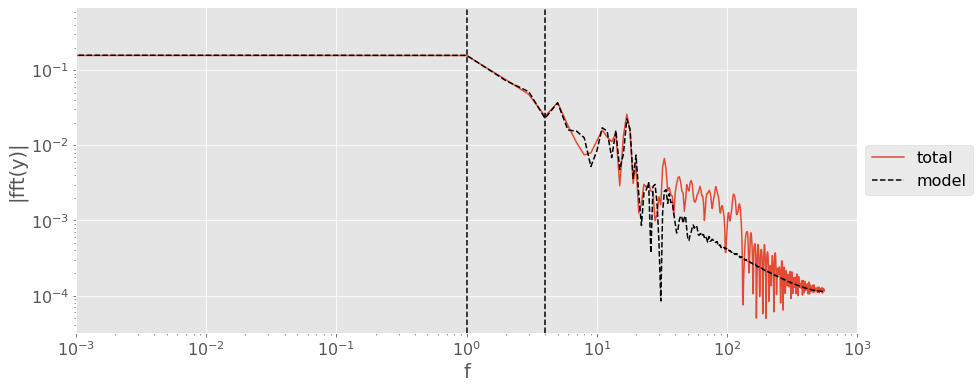

In [101]:
plot_fft(data_one_v2['X_train'], data_one_v2['y_train'], model=model_v2, xlim=(1e-3, 1e3), logx=True, logy=True)

# results

When the input to the model is just time:

X.shape = (N, 1)

Then the Mscale_v1 network works well.

When the input is time and q, s1, theta1

X.shape = (N, 4)

Then the Mscale_v1 network does NOT work well

The resnet didn't work either

However, Mscale_v2 did work but 2nd input didn't work as well.


I think scaling the other inputs might be a good idea

Indeed the mass-ratio value is about 6 and simply diving by 6 so that it is ~1 helped alot.

Having time \in [-1,0] also seems to help a lot to get the ringdown


Both mscale_[v1,v2] can work - i got better performance with v2 but both could probably work

# trying single waveform with multiple inputs but separate sub-networks, one for time and other for other

In [102]:
import wispy.mscalev2

In [103]:
data_one_v2['X_train']

array([[-1.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.99105546e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-9.98211091e-01,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       ...,
       [-1.78890877e-03,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [-8.94454383e-04,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00],
       [ 0.00000000e+00,  6.72379423e+00,  9.90000000e-01,
         1.38988770e+00]])

In [104]:
inputs = np.array([
    [1,1],
    [2,2],
    [3,3]
])

In [105]:
wispy.mscalev2.ScaleLayer(10)(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[10, 10],
       [20, 20],
       [30, 30]])>

In [106]:
def make_scale_tensor(input_shape, scale_dimension, scale, dtype):
    scales = np.ones(shape=(input_shape,), dtype=dtype)
    scales[scale_dimension] = scale
    return tf.convert_to_tensor(scales)

In [107]:
make_scale_tensor(inputs.shape[1], 0, 1, dtype=np.float32)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 1.], dtype=float32)>

In [108]:
class ScaleLayer_v2(tf.keras.layers.Layer):
    def __init__(self, scale_tensor, **kwargs):
        super(ScaleLayer_v2, self).__init__()
        self.scale_tensor = scale_tensor

    def call(self, inputs):
        return tf.math.multiply(inputs, self.scale_tensor)

    def get_config(self):
        config = super(ScaleLayer_v2, self).get_config()
        config.update({"scale_tensor": self.scale_tensor})
        return config

In [109]:
inputs.dtype

dtype('int64')

In [110]:
inputs

array([[1, 1],
       [2, 2],
       [3, 3]])

In [111]:
ScaleLayer_v2(make_scale_tensor(input_shape=inputs.shape[1], scale_dimension=0, scale=10, dtype=np.int64))(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[10,  1],
       [20,  2],
       [30,  3]])>

In [112]:
ScaleLayer_v2(make_scale_tensor(input_shape=inputs.shape[1], scale_dimension=1, scale=10, dtype=np.int64))(inputs)

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[ 1, 10],
       [ 2, 20],
       [ 3, 30]])>

In [113]:
import tensorflow as tf
from wispy.mscalev2 import build_subnetwork

In [114]:
def build_model_custom_scales(
    input_shape=1,
    output_shape=1,
    units=[128],
    activation="relu",
    n_blocks=[2],
    scales=[1],
    layers_per_block=3,
    scale_dimension=0,
    dtype=np.float64
):
    """
    scale_dimension=0 means that the first column of X_train will be scaled by `scales`
    and the other dimensions will not be scaled.
    """
    assert (
        len(scales) == len(n_blocks) == len(units)
    ), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scale_tensor = make_scale_tensor(input_shape, scale_dimension, scale, dtype=dtype)
        scaled_input = ScaleLayer_v2(scale_tensor)(input_layer)
#         scaled_input = ScaleLayer(scale)(input_layer)
        xs.append(
            build_subnetwork(
                input_tensor=scaled_input,
                units=units[i],
                activation=activation,
                n_blocks=n_blocks[i],
                layers_per_block=layers_per_block,
            )
        )

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(
        output_layer
    )
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [115]:
epochs = 1000
batch_size = data_one_v2['X_train'].shape[0]
# batch_size = 32
print(f"batch_size: {batch_size}")

model_name = "mscalev2_custom_scale"

model_params_dict = dict(
    input_shape=data_one_v2['X_train'].shape[1],
    output_shape=data_one_v2['y_train'].shape[1],
    units = [128,128,128],
    activation = "s2relu",
    n_blocks = [2,2,2],
    scales = [1,10,100],
    layers_per_block = 3,
    scale_dimension = 0,
    dtype = np.float32
)

# model_name = "mscalev1"

# model_params_dict = dict(
#     input_shape=data_one_v2['X_train'].shape[1],
#     output_shape=data_one_v2['y_train'].shape[1],
#     mscale_units = 2048,
#     mscale_activation = 's2relu',
#     nscales = 2048,
#     scale_name = 'linear',
#     units = [256],
#     activation = 's2relu',
#     mscale_bias_initializer = [-0.05, 0.05]
# )

# model_name = "mscalev2"

# model_params_dict = dict(
#     input_shape=data_one_v2['X_train'].shape[1],
#     output_shape=data_one_v2['y_train'].shape[1],
#     units = [128,128,128],
#     activation = "s2relu",
#     n_blocks = [1,1,3],
#     scales = [1,10,100],
#     layers_per_block = 5
# )

# model_name = "resnet"

# model_params_dict = dict(
#     input_shape=data_one_v2['X_train'].shape[1],
#     output_shape=data_one_v2['y_train'].shape[1],
#     width = 256,
#     num_blocks = 1,
#     group_norm = True,
#     groups = 1,
#     batch_norm = False,
#     momentum = 0.9
# )


extra_params_dict = dict(
    loss = 'mae',
    metrics = ['mse'],
    lr = 1e-3,
    amsgrad = False
)

verbose=0
# callbacks=None
callbacks=[pugna.callbacks.PrintDot()]
sample_weight=None

model_v2_custom_scale = get_compiled_model(
    model_name=model_name,
    model_params_dict=model_params_dict,
    extra_params_dict=extra_params_dict)

batch_size: 1119


In [116]:
model_v2_custom_scale.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
scale_layer_v2_7 (ScaleLayer_v2 (None, 4)            0           input_6[0][0]                    
__________________________________________________________________________________________________
scale_layer_v2_8 (ScaleLayer_v2 (None, 4)            0           input_6[0][0]                    
__________________________________________________________________________________________________
scale_layer_v2_9 (ScaleLayer_v2 (None, 4)            0           input_6[0][0]                    
____________________________________________________________________________________________

In [117]:
# data_one_v2['X_train'],
# data_one_v2['y_train'],
print("starting fit")
starttime = datetime.datetime.now()
history_v2_custom_scale = model_v2_custom_scale.fit(
    data_one_v2['X_train'],
    data_one_v2['y_train'],
    epochs=epochs,
    validation_data=(data_one_v2['X_val'], data_one_v2['y_val']),
    batch_size=batch_size,
    callbacks=callbacks,
    sample_weight=sample_weight,
    verbose=verbose
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print("")
print("fit complete")
print(f"The time cost: {duration}")

starting fit

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................

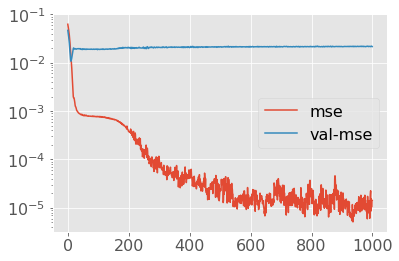

In [118]:
plt.figure()
plt.plot(history_v2_custom_scale.history['mse'], label='mse')
plt.plot(history_v2_custom_scale.history['val_mse'], label='val-mse')
plt.yscale('log')
plt.legend()

In [119]:
yhat_v2_custom_scale = model_v2_custom_scale.predict(data_one_v2['X_train'])
# yhat_v2_custom_scale = model_v2_custom_scale.predict(data_one_v2['X_train_FAKE'])

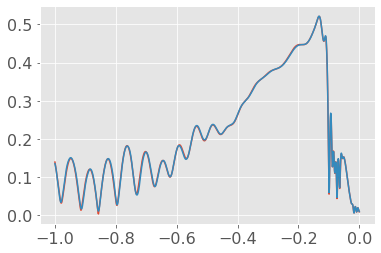

In [120]:
plt.figure()
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0])
plt.plot(data_one_v2['X_train'][:,0], yhat_v2_custom_scale[:,0])

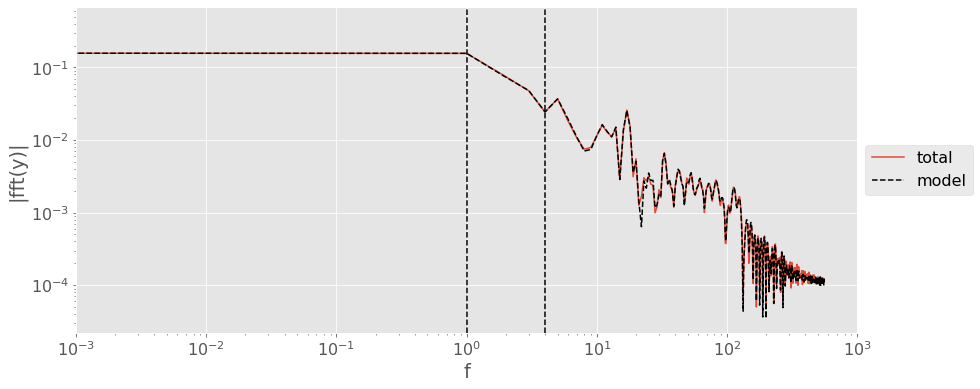

In [121]:
plot_fft(data_one_v2['X_train'], data_one_v2['y_train'], model=model_v2_custom_scale, xlim=(1e-3, 1e3), logx=True, logy=True)

# compare

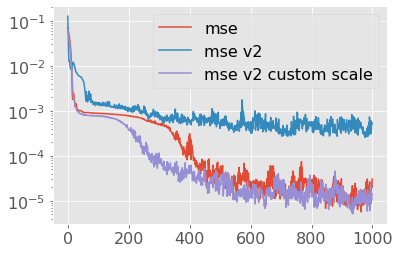

In [122]:
plt.figure()
plt.plot(history.history['mse'], label='mse')
plt.plot(history_v2.history['mse'], label='mse v2')
plt.plot(history_v2_custom_scale.history['mse'], label='mse v2 custom scale')
plt.yscale('log')
plt.legend()

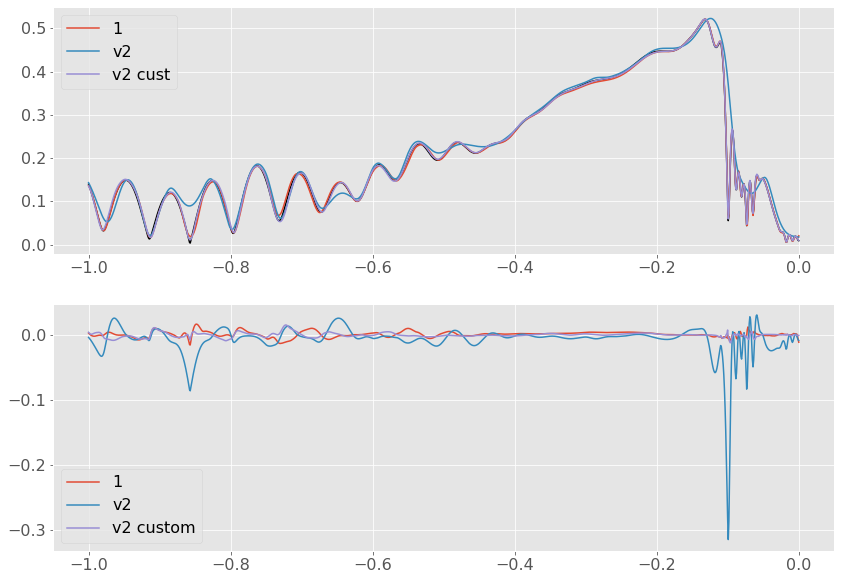

In [123]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0], c='k')
plt.plot(data_one_v2['X_train'][:,0], yhat[:,0], label='1')
plt.plot(data_one_v2['X_train'][:,0], yhat_v2[:,0], label='v2')
plt.plot(data_one_v2['X_train'][:,0], yhat_v2_custom_scale[:,0], label='v2 cust')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0]-yhat[:,0], label='1')
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0]-yhat_v2[:,0], label='v2')
plt.plot(data_one_v2['X_train'][:,0], data_one_v2['y_train'][:,0]-yhat_v2_custom_scale[:,0], label='v2 custom')
plt.legend()

results

(N, 1) (time) works with Mscale

(N, 4) (time, q, s1, theta) doesn't work with Msclae

(N, 4) (time, q, s1, theta) modify mscale so that the scale only applies to the time fixes things and it works!